In [7]:
from pathlib import Path
from datetime import datetime
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [8]:

# ================= CONFIG =================
ROOT = Path.cwd()
DATASET_DIR = ROOT / "dataset"
CACHE_DIR = ROOT / "features_cache"
CACHE_DIR.mkdir(exist_ok=True)

IMG_SIZE = 224
MAX_SEQ_LENGTH = 60
NUM_FEATURES = 1280
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4

WEIGHT_FILE = ROOT / "best_model_mobilenetv2_lstm.weights.h5"
LOGDIR = ROOT / "logs" / datetime.now().strftime("%Y%m%d-%H%M%S")
LOGDIR.mkdir(parents=True, exist_ok=True)


In [9]:

# ================= DATA HELPERS =================
def list_videos():
    rows = []
    for split in ["train", "test"]:
        for cls in sorted((DATASET_DIR / split).iterdir()):
            if not cls.is_dir():
                continue
            for v in cls.iterdir():
                if v.suffix.lower() in [".mp4", ".avi", ".mov", ".mkv"]:
                    rows.append({
                        "split": split,
                        "label": cls.name,
                        "path": str(v)
                    })
    return pd.DataFrame(rows)

def crop_center(frame):
    h, w = frame.shape[:2]
    m = min(h, w)
    return frame[(h-m)//2:(h+m)//2, (w-m)//2:(w+m)//2]

def load_frames(path):
    cap = cv2.VideoCapture(path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(total-1, 0), MAX_SEQ_LENGTH, dtype=int)

    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if i in idxs:
            frame = crop_center(frame)
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = frame[:, :, ::-1]
            frames.append(frame)
        i += 1

    cap.release()
    return np.array(frames)


In [10]:

# ================= FEATURE EXTRACTOR =================
def build_feature_extractor():
    base = keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False
    inp = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inp)
    out = base(x)
    return keras.Model(inp, out)

feature_extractor = build_feature_extractor()


In [11]:

# ================= FEATURE CACHE =================
def extract_and_cache(path):
    cache = CACHE_DIR / f"mobilenet_{Path(path).stem}_{MAX_SEQ_LENGTH}.npz"
    if cache.exists():
        d = np.load(cache)
        return d["x"], d["m"]

    frames = load_frames(path)
    x = np.zeros((MAX_SEQ_LENGTH, NUM_FEATURES), np.float32)
    m = np.zeros(MAX_SEQ_LENGTH, bool)

    if len(frames) > 0:
        feats = feature_extractor.predict(frames.astype("float32"), verbose=0)
        x[:len(feats)] = feats[:MAX_SEQ_LENGTH]
        m[:len(feats)] = True

    np.savez(cache, x=x, m=m)
    return x, m


In [12]:

# ================= PREP DATA =================
df = list_videos()
train_df = df[df.split == "train"].reset_index(drop=True)
test_df = df[df.split == "test"].reset_index(drop=True)

classes = sorted(train_df.label.unique())
label_lookup = keras.layers.StringLookup(vocabulary=classes, num_oov_indices=0)

def build_set(df):
    X = np.zeros((len(df), MAX_SEQ_LENGTH, NUM_FEATURES))
    M = np.zeros((len(df), MAX_SEQ_LENGTH), bool)
    y = label_lookup(df.label.values[..., None]).numpy().flatten()

    for i, r in enumerate(df.itertuples()):
        X[i], M[i] = extract_and_cache(r.path)

    return (X, M), y

(train_X, train_M), y_train = build_set(train_df)
(test_X, test_M), y_test = build_set(test_df)


In [13]:

# ================= MODEL =================
inp_f = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
inp_m = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

x = keras.layers.Bidirectional(
    keras.layers.LSTM(256, return_sequences=True)
)(inp_f, mask=inp_m)
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(128, activation="relu")(x)
out = keras.layers.Dense(len(classes), activation="softmax")(x)

model = keras.Model([inp_f, inp_m], out)
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [14]:

# ================= TRAIN =================
weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)

model.fit(
    [train_X, train_M], y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=dict(enumerate(weights)),
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            WEIGHT_FILE, save_best_only=True, save_weights_only=True
        ),
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        keras.callbacks.TensorBoard(LOGDIR)
    ]
)


Epoch 1/50

105/105 [==============================] - 54s 312ms/step - loss: 1.5936 - accuracy: 0.5396 - val_loss: 3.5460 - val_accuracy: 0.0239
Epoch 2/50
105/105 [==============================] - 25s 241ms/step - loss: 0.4498 - accuracy: 0.9376 - val_loss: 5.3396 - val_accuracy: 0.0239
Epoch 3/50
105/105 [==============================] - 25s 239ms/step - loss: 0.1314 - accuracy: 0.9772 - val_loss: 6.0405 - val_accuracy: 0.0239
Epoch 4/50
105/105 [==============================] - 25s 240ms/step - loss: 0.0737 - accuracy: 0.9880 - val_loss: 6.6596 - val_accuracy: 0.0239
Epoch 5/50
105/105 [==============================] - 26s 245ms/step - loss: 0.0258 - accuracy: 0.9988 - val_loss: 7.2796 - val_accuracy: 0.0239
Epoch 6/50
105/105 [==============================] - 26s 244ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 7.9136 - val_accuracy: 0.0239
Epoch 7/50
105/105 [==============================] - 25s 241ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 8.2369 - val_a

11/11 [==============================] - 9s 126ms/step

Classification Report:
               precision    recall  f1-score   support

BaseballPitch       0.97      0.97      0.97        36
    Billiards       1.00      1.00      1.00        36
      Bowling       0.55      1.00      0.71        36
BrushingTeeth       0.53      1.00      0.69        31
    HorseRace       0.97      1.00      0.98        32
  JumpingJack       0.66      0.97      0.78        30
     LongJump       1.00      0.70      0.82        30
       Mixing       0.82      0.90      0.86        30
 MoppingFloor       0.00      0.00      0.00        30
PlayingGuitar       0.00      0.00      0.00        36

     accuracy                           0.76       327
    macro avg       0.65      0.75      0.68       327
 weighted avg       0.65      0.76      0.68       327



c:\Users\wwwad\Desktop\MachineLearning Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wwwad\Desktop\MachineLearning Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wwwad\Desktop\MachineLearning Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

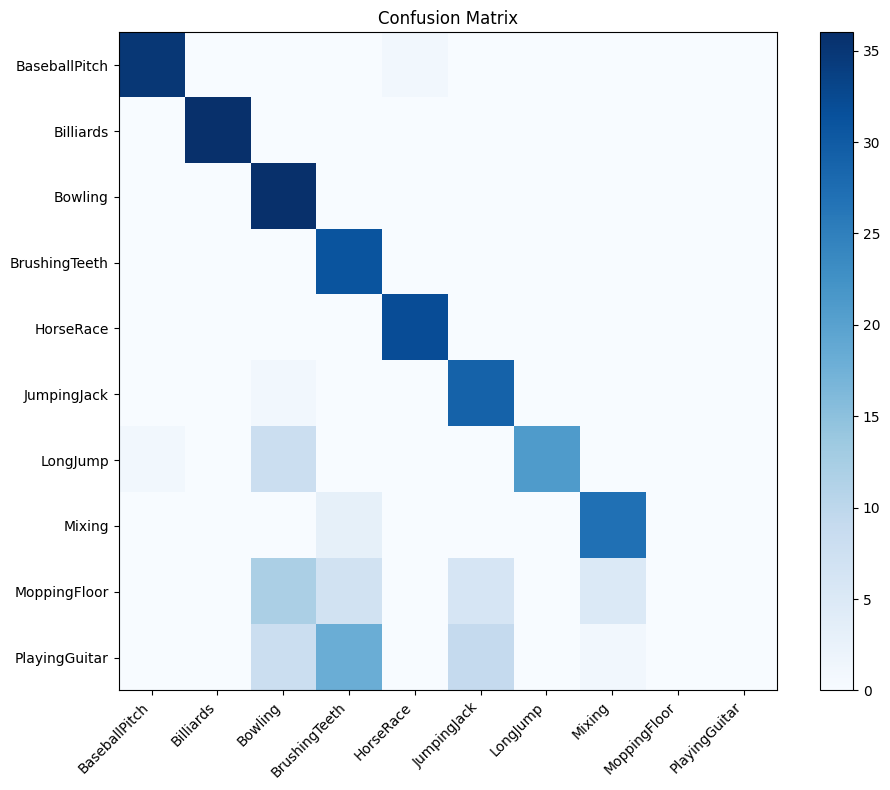

In [ ]:

# ================= EVALUATION =================
preds = np.argmax(model.predict([test_X, test_M]), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=classes))

cm = confusion_matrix(y_test, preds,)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.colorbar()
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [16]:

# ================= SINGLE VIDEO TEST =================
def predict_video_file(video_path, top_k=5):
    feats, mask = extract_and_cache(video_path)
    preds = model.predict(
        [feats[np.newaxis, ...], mask[np.newaxis, ...]],
        verbose=0
    )[0]

    idxs = np.argsort(preds)[::-1][:top_k]
    print(f"\nPredictions for {video_path}")
    for i in idxs:
        print(f"{classes[i]:<20s} : {preds[i]*100:.2f}%")

# ✅ FIXED PATH
predict_video_file(r"dataset\test\Mixing\Mixing (1).avi")



Predictions for dataset\test\Mixing\Mixing (1).avi
Mixing               : 42.30%
BrushingTeeth        : 13.88%
Bowling              : 10.00%
JumpingJack          : 9.33%
LongJump             : 5.17%
